## Needed Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_absolute_error

### Importing CSV Files and preprocessing ETH Data

In [2]:
# Ethereum Prices and dates
df_eth_prices = pd.read_csv("ETH_Historical_Price.csv") 

# Turn timestamps into dates
df_eth_prices['timestamp'] = [dt.datetime.fromtimestamp(i).strftime('%d-%m-%Y') for i in df_eth_prices['timestamp']]

# Reverse the dataframe based on the dates
df_eth_prices = df_eth_prices.iloc[::-1]

# Preprocess the data
df_eth_prices.drop(['high','low','close'], 1, inplace=True)

# Converting timestamp dates as a datetime object
datelist_train = list(df_eth_prices['timestamp'])
datelist_train = [dt.datetime.strptime(date, '%d-%m-%Y').date() for date in datelist_train]
df_eth_prices['Dates'] = datelist_train
df_eth_prices = df_eth_prices.drop('timestamp', 1)



# sorting by first name
#df_eth_prices.sort_values("Dates", inplace = True)
df_eth_prices.reset_index(drop=True, inplace=True)
df_eth_prices.index = df_eth_prices['Dates']
df_eth_prices.drop_duplicates(subset ="Dates",keep = 'first', inplace = True)

df_eth_prices = df_eth_prices[534:1977]
df_eth_prices

,open,Dates
Dates,,
2017-01-22,10.710000,2017-01-22
2017-01-23,10.780000,2017-01-23
2017-01-24,10.510000,2017-01-24
2017-01-25,10.510000,2017-01-25
2017-01-26,10.650000,2017-01-26
...,...,...
2020-12-30,731.743102,2020-12-30
2020-12-31,752.399699,2020-12-31
2021-01-01,737.192624,2021-01-01


In [3]:
# Implementing weekly prices and adding them to the ethereum price dataframe

weekly_price_list = []
closing_prices = list(df_eth_prices['open'])

temp_list = []
for i in range(0,len(closing_prices)):
    if (i + 1) % 7 == 0:
        temp_list.append(closing_prices[i])
        weekly_price_list.append(temp_list)
        temp_list = []
    else:
        temp_list.append(closing_prices[i])
        
    
mean_weekly_list = []    
for i in weekly_price_list:
    mean_weekly_list.append(np.mean(i))
    
len(mean_weekly_list)

206

In [4]:
trends_weekly_df_eth = pd.read_csv("ether_extended_trends.csv")
trends_weekly_df_eth.columns = trends_weekly_df_eth.iloc[0]
trends_weekly_df_eth = trends_weekly_df_eth[1:]
trend_values_eth = trends_weekly_df_eth['Ether: (Dünya Genelinde)']

modify_integers_df = trend_values_eth
new_integers = []
for i in modify_integers_df:
    if(i == "<1"):
        new_integers.append(1)
    else:
        new_integers.append(i)
        
trends_weekly_df_eth.drop(['Ether: (Dünya Genelinde)'], 1, inplace=True)
trends_weekly_df_eth['Trend Values'] = new_integers
trends_weekly_df_eth['Trend Values'] = trends_weekly_df_eth['Trend Values'].astype("int")
trends_weekly_df_eth = trends_weekly_df_eth[3:]
trends_weekly_df_eth

Hafta,Trend Values
2017-01-22,3
2017-01-29,3
2017-02-05,2
2017-02-12,1
2017-02-19,2
...,...
2020-11-29,38
2020-12-06,39
2020-12-13,40
2020-12-20,41


In [5]:
main_df = pd.DataFrame() 
main_df['Trend Values'] = trends_weekly_df_eth['Trend Values']
main_df['Mean Weekly Prices'] = mean_weekly_list
main_df['Mean Weekly Prices'] = main_df['Mean Weekly Prices'].astype("float")
main_df

,Trend Values,Mean Weekly Prices
2017-01-22,3,10.601429
2017-01-29,3,10.794286
2017-02-05,2,11.298571
2017-02-12,1,12.468571
2017-02-19,2,12.944286
...,...,...
2020-11-29,38,585.453646
2020-12-06,39,575.340601
2020-12-13,40,610.192064
2020-12-20,41,622.901381


<AxesSubplot:>

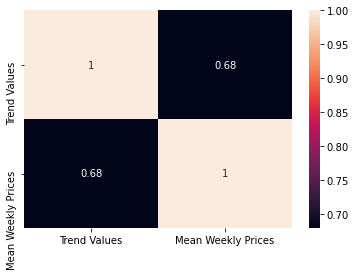

In [6]:
sns.heatmap(main_df.corr(),annot = True)

## Graphs to visualize the Ethereum data

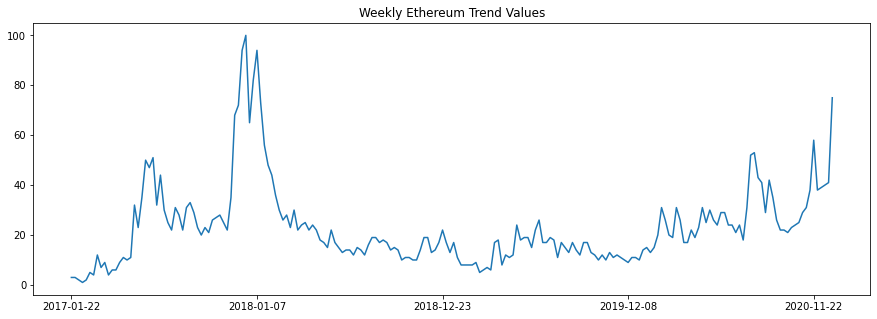

In [229]:
# Mean Weekly Prices For Ethereum
main_df['Trend Values'].plot(figsize=(15, 5))
plt.title("Weekly Ethereum Trend Values")
plt.show()

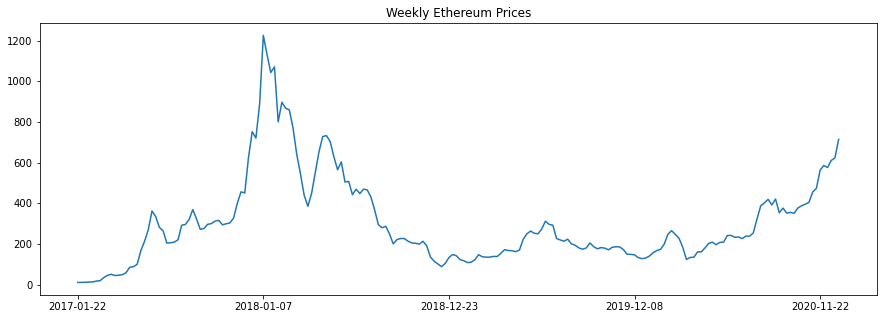

In [230]:
# Mean Weekly Prices For Ethereum
main_df['Mean Weekly Prices'].plot(figsize=(15, 5))
plt.title("Weekly Ethereum Prices")
plt.show()

In [231]:
# Create a week feature
main_df['Week Feature'] = main_df.index
main_df

,Trend Values,Mean Weekly Prices,Week Feature
2017-01-22,3,10.601429,2017-01-22
2017-01-29,3,10.794286,2017-01-29
2017-02-05,2,11.298571,2017-02-05
2017-02-12,1,12.468571,2017-02-12
2017-02-19,2,12.944286,2017-02-19
...,...,...,...
2020-11-29,38,585.453646,2020-11-29
2020-12-06,39,575.340601,2020-12-06
2020-12-13,40,610.192064,2020-12-13
2020-12-20,41,622.901381,2020-12-20


In [232]:
# Check null values
main_df.isnull().sum()

Trend Values          0
Mean Weekly Prices    0
Week Feature          0
dtype: int64

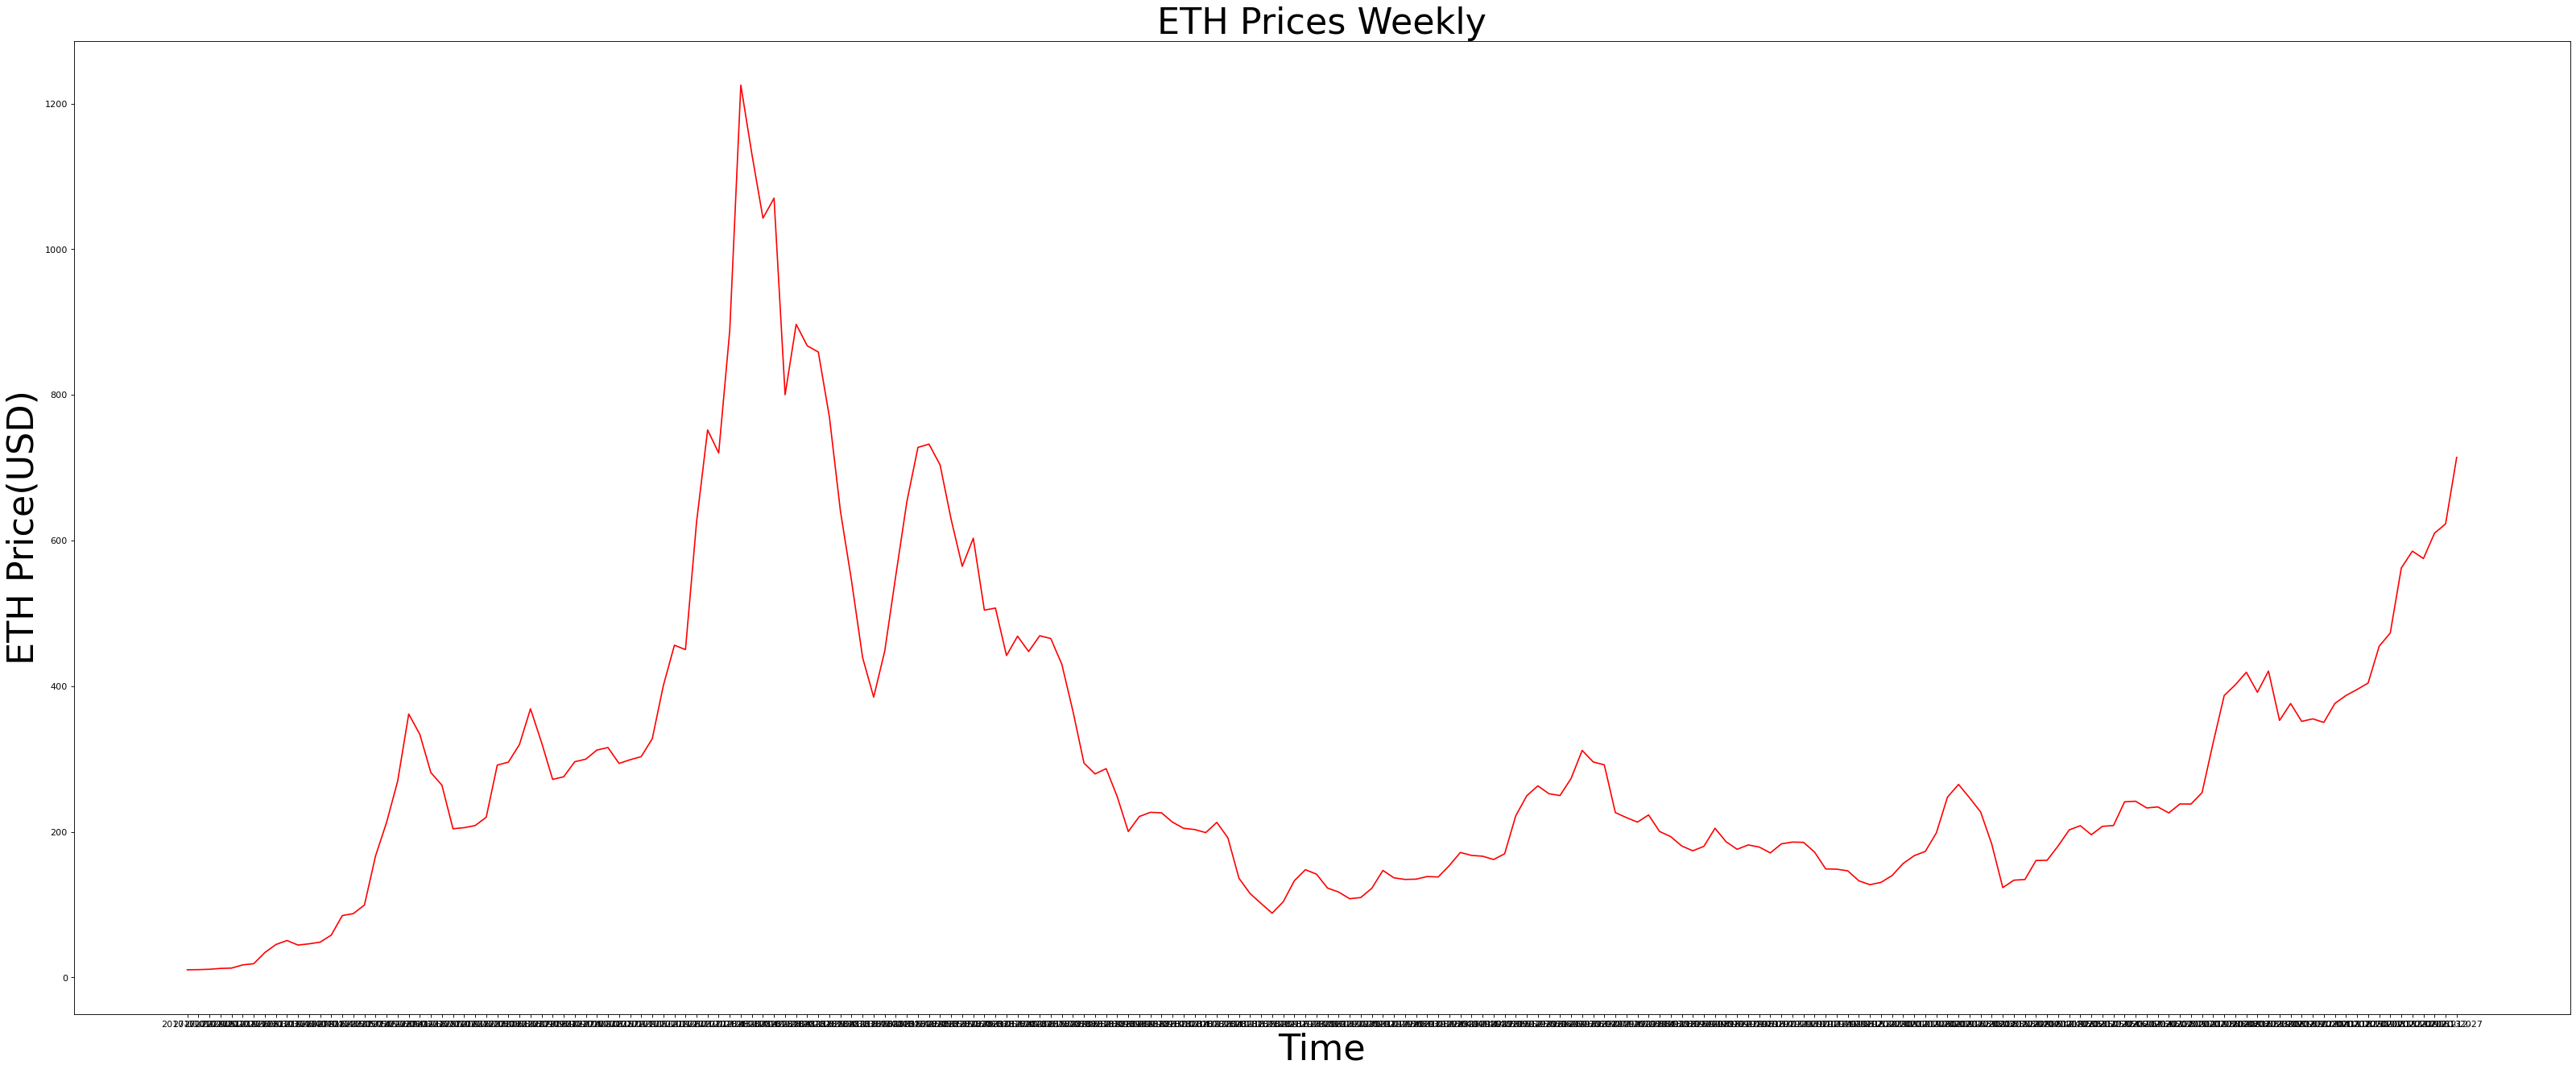

In [233]:
# The Prices of ETH over time
plt.figure(figsize=(50, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(main_df['Mean Weekly Prices'], color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.show()

### Splitting the data for train and test

In [234]:
# Converting dates as a datetime object

datelist_train = list(main_df['Week Feature'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
main_df.index = datelist_train
main_df

,Trend Values,Mean Weekly Prices,Week Feature
2017-01-22,3,10.601429,2017-01-22
2017-01-29,3,10.794286,2017-01-29
2017-02-05,2,11.298571,2017-02-05
2017-02-12,1,12.468571,2017-02-12
2017-02-19,2,12.944286,2017-02-19
...,...,...,...
2020-11-29,38,585.453646,2020-11-29
2020-12-06,39,575.340601,2020-12-06
2020-12-13,40,610.192064,2020-12-13
2020-12-20,41,622.901381,2020-12-20


In [235]:
# Splitting the data to train and test based on the prediction day we want

date_string = "21 June, 2019"
#possible parameter %H:%M:%S
dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = main_df.loc[main_df.index <= dt_onject_split].copy()
data_test = main_df.loc[main_df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)

Data train shape (126, 3)
Data test shape (80, 3)


In [236]:
def create_features_with_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day

    
    X = df[['Month','Year','Day of Month','Trend Values']]
    if label:
        y = df[label]
        return X, y
    return X



def create_features_without_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day

    
    X = df[['Month','Year','Day of Month']]
    if label:
        y = df[label]
        return X, y
    return X

In [237]:
### Create train and test data

In [238]:
X_train, y_train = create_features_with_google_trends(data_train, label='Mean Weekly Prices')
X_test, y_test = create_features_with_google_trends(data_test, label='Mean Weekly Prices')

X_train['Trend Values'] = X_train['Trend Values'].astype(int)
X_test['Trend Values'] = X_test['Trend Values'].astype(int)

X_train

<ipython-input-238-a7dca86bbf66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Trend Values'] = X_train['Trend Values'].astype(int)
<ipython-input-238-a7dca86bbf66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Trend Values'] = X_test['Trend Values'].astype(int)


,Month,Year,Day of Month,Trend Values
2017-01-22,1,2017,22,3
2017-01-29,1,2017,29,3
2017-02-05,2,2017,5,2
2017-02-12,2,2017,12,1
2017-02-19,2,2017,19,2
...,...,...,...,...
2019-05-19,5,2019,19,18
2019-05-26,5,2019,26,19
2019-06-02,6,2019,2,19
2019-06-09,6,2019,9,15


In [239]:
X_train_second, y_train_second = create_features_without_google_trends(data_train, label='Mean Weekly Prices')
X_test_second, y_test_second = create_features_without_google_trends(data_test, label='Mean Weekly Prices')


X_train_second

,Month,Year,Day of Month
2017-01-22,1,2017,22
2017-01-29,1,2017,29
2017-02-05,2,2017,5
2017-02-12,2,2017,12
2017-02-19,2,2017,19
...,...,...,...
2019-05-19,5,2019,19
2019-05-26,5,2019,26
2019-06-02,6,2019,2
2019-06-09,6,2019,9


## Create an LSTM model. 

In [240]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

In [241]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()

In [242]:
# Turning input X_Train to appropriate shape for LSTM    ((n_samples, time_steps, features))
x_training_set = X_train.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

y_train = pd.DataFrame(y_train)
list(y_train['Mean Weekly Prices'])
y_train_values = [float(i) for i in y_train['Mean Weekly Prices']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y.fit_transform(y_train_values)

In [243]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
26/26 [==============================] - 2s 1ms/step - loss: 0.0868
Epoch 2/100
26/26 [==============================] - 0s 971us/step - loss: 0.0381
Epoch 3/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0438
Epoch 4/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0314
Epoch 5/100
26/26 [==============================] - 0s 956us/step - loss: 0.0341
Epoch 6/100
26/26 [==============================] - 0s 944us/step - loss: 0.0318
Epoch 7/100
26/26 [==============================] - 0s 975us/step - loss: 0.0308
Epoch 8/100
26/26 [==============================] - 0s 981us/step - loss: 0.0336
Epoch 9/100
26/26 [==============================] - 0s 923us/step - loss: 0.0301
Epoch 10/100
26/26 [==============================] - 0s 955us/step - loss: 0.0219
Epoch 11/100
26/26 [==============================] - 0s 957us/step - loss: 0.0290
Epoch 12/100
26/26 [==============================] - 0s 918us/step - loss: 0.0287
Epoch 13/100
26/26 

Epoch 100/100
26/26 [==============================] - 0s 889us/step - loss: 0.0090


In [244]:
test_set = X_test.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 4))
inputs = min_max_scaler.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 4))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 4))
predicted_price = min_max_scaler_y.inverse_transform(predicted_price)


In [245]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,predicted_price,squared=False)

305.5153694639953

In [246]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,predicted_price)

250.91304376654244

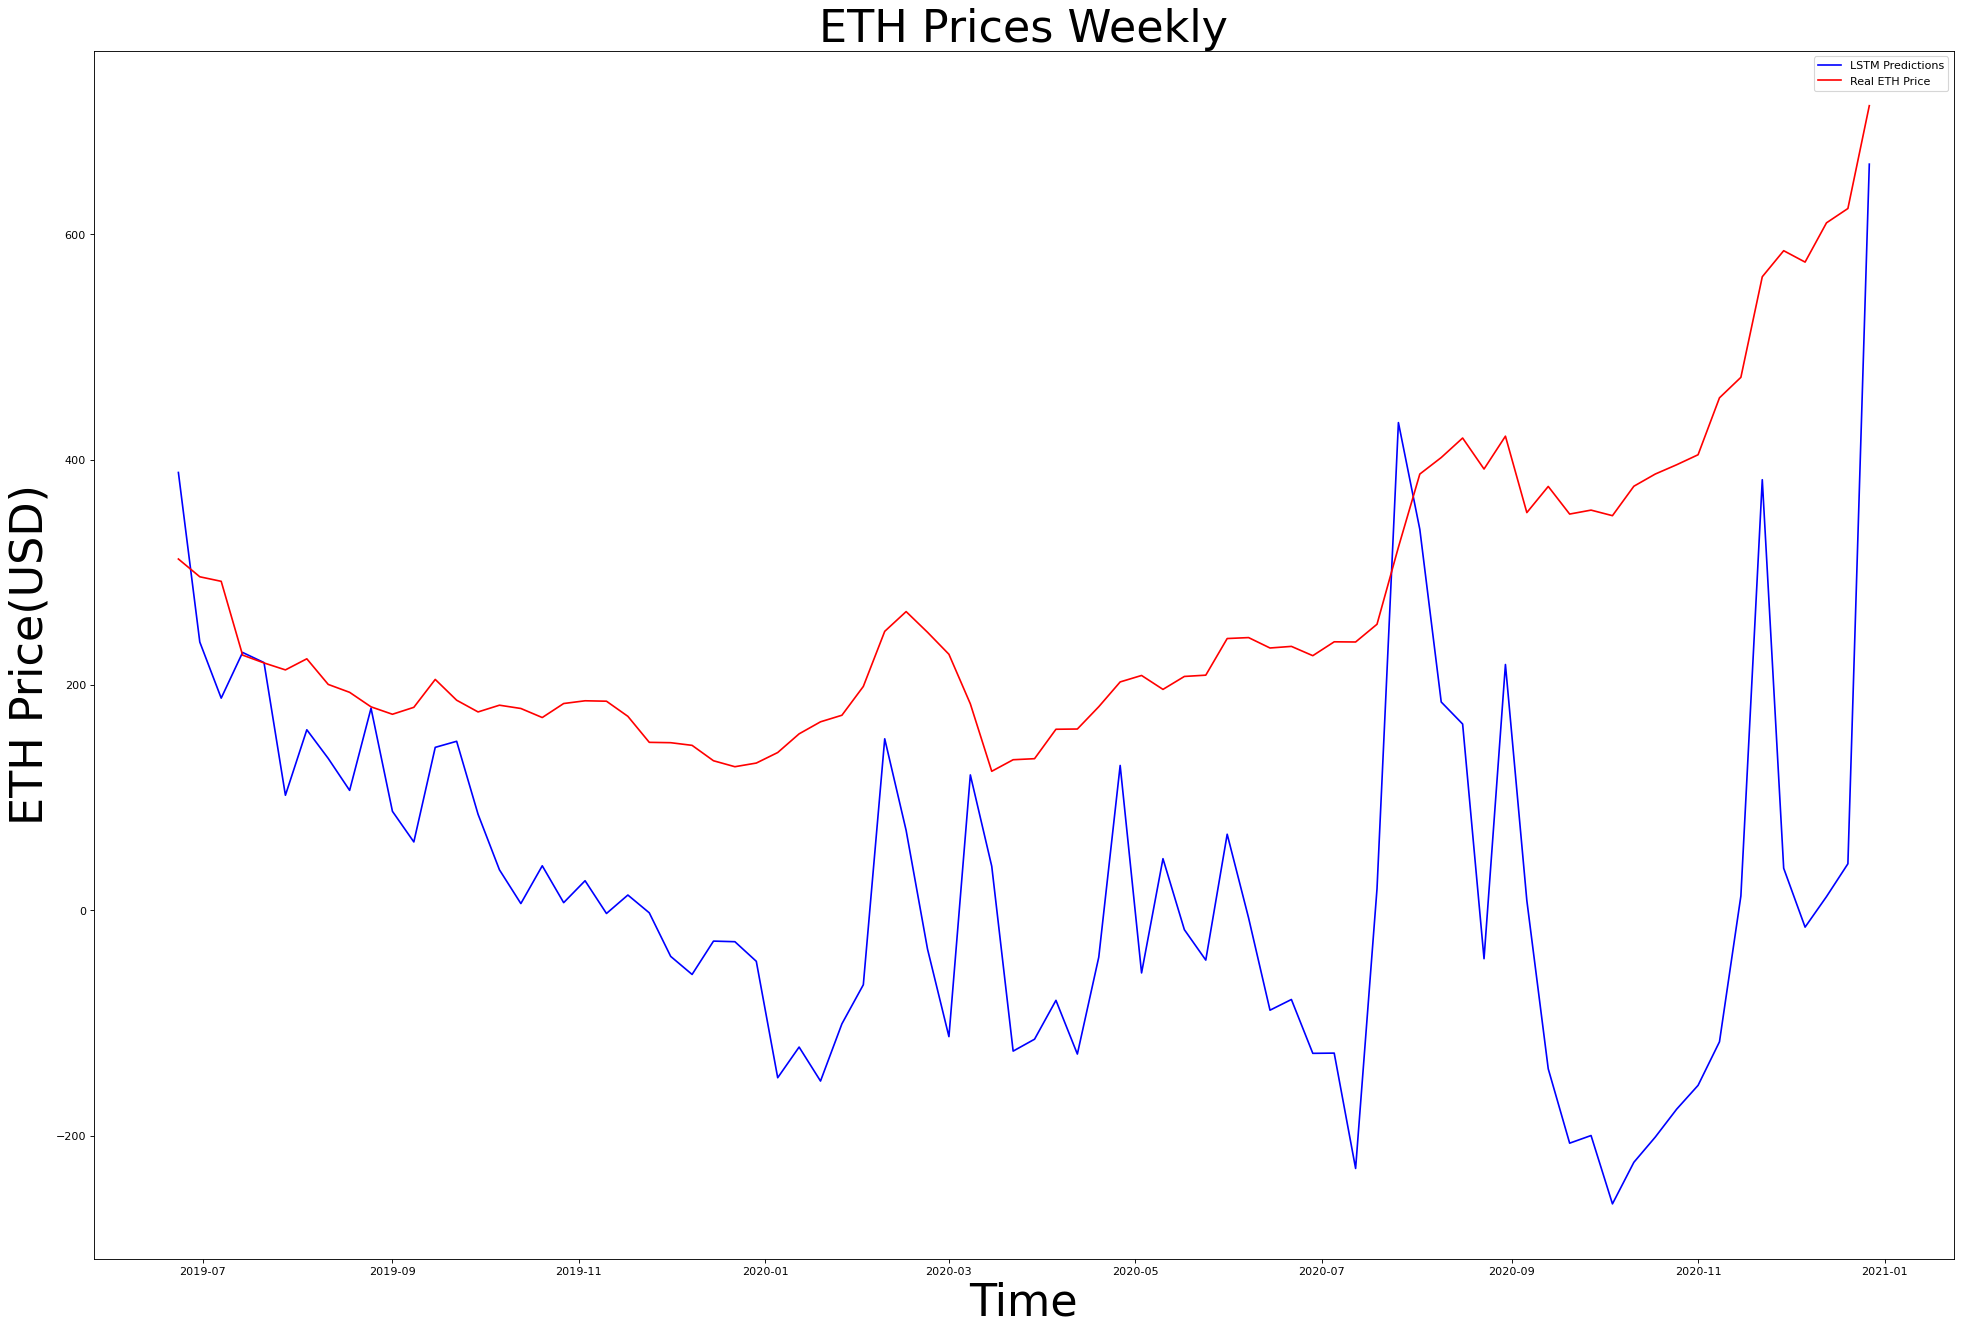

In [247]:
y_test_values = [float(i) for i in y_test]

plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test.index,y_test_values, color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.legend()
plt.show()

In [248]:
# Previous predicted prices were for feaures with google trends, now predicting for without google trends 
from sklearn.preprocessing import MinMaxScaler
min_max_scaler_second = MinMaxScaler()
min_max_scaler_y_second = MinMaxScaler()

In [249]:
# Turning input X_Train to appropriate shape for LSTM    ((n_samples, time_steps, features))
x_training_set = X_train_second.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler_second.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

In [250]:
y_train = pd.DataFrame(y_train_second)
list(y_train['Mean Weekly Prices'])
y_train_values = [float(i) for i in y_train['Mean Weekly Prices']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y_second.fit_transform(y_train_values)

In [251]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
26/26 [==============================] - 2s 932us/step - loss: 0.0916
Epoch 2/100
26/26 [==============================] - 0s 868us/step - loss: 0.0468
Epoch 3/100
26/26 [==============================] - 0s 898us/step - loss: 0.0398
Epoch 4/100
26/26 [==============================] - 0s 878us/step - loss: 0.0386
Epoch 5/100
26/26 [==============================] - 0s 918us/step - loss: 0.0456
Epoch 6/100
26/26 [==============================] - 0s 868us/step - loss: 0.0462
Epoch 7/100
26/26 [==============================] - 0s 908us/step - loss: 0.0396
Epoch 8/100
26/26 [==============================] - 0s 889us/step - loss: 0.0427
Epoch 9/100
26/26 [==============================] - 0s 986us/step - loss: 0.0546
Epoch 10/100
26/26 [==============================] - 0s 867us/step - loss: 0.0441
Epoch 11/100
26/26 [==============================] - 0s 1ms/step - loss: 0.0396
Epoch 12/100
26/26 [==============================] - 0s 957us/step - loss: 0.0432
Epoch 13/100
26

26/26 [==============================] - 0s 878us/step - loss: 0.0219


In [252]:
test_set = X_test_second.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 3))
inputs = min_max_scaler_second.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 3))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 3))
predicted_price = min_max_scaler_y_second.inverse_transform(predicted_price)

In [253]:
mean_squared_error(y_test,predicted_price,squared=False)

921.500615281648

In [254]:
mean_absolute_error(y_test,predicted_price)

813.7518198485401

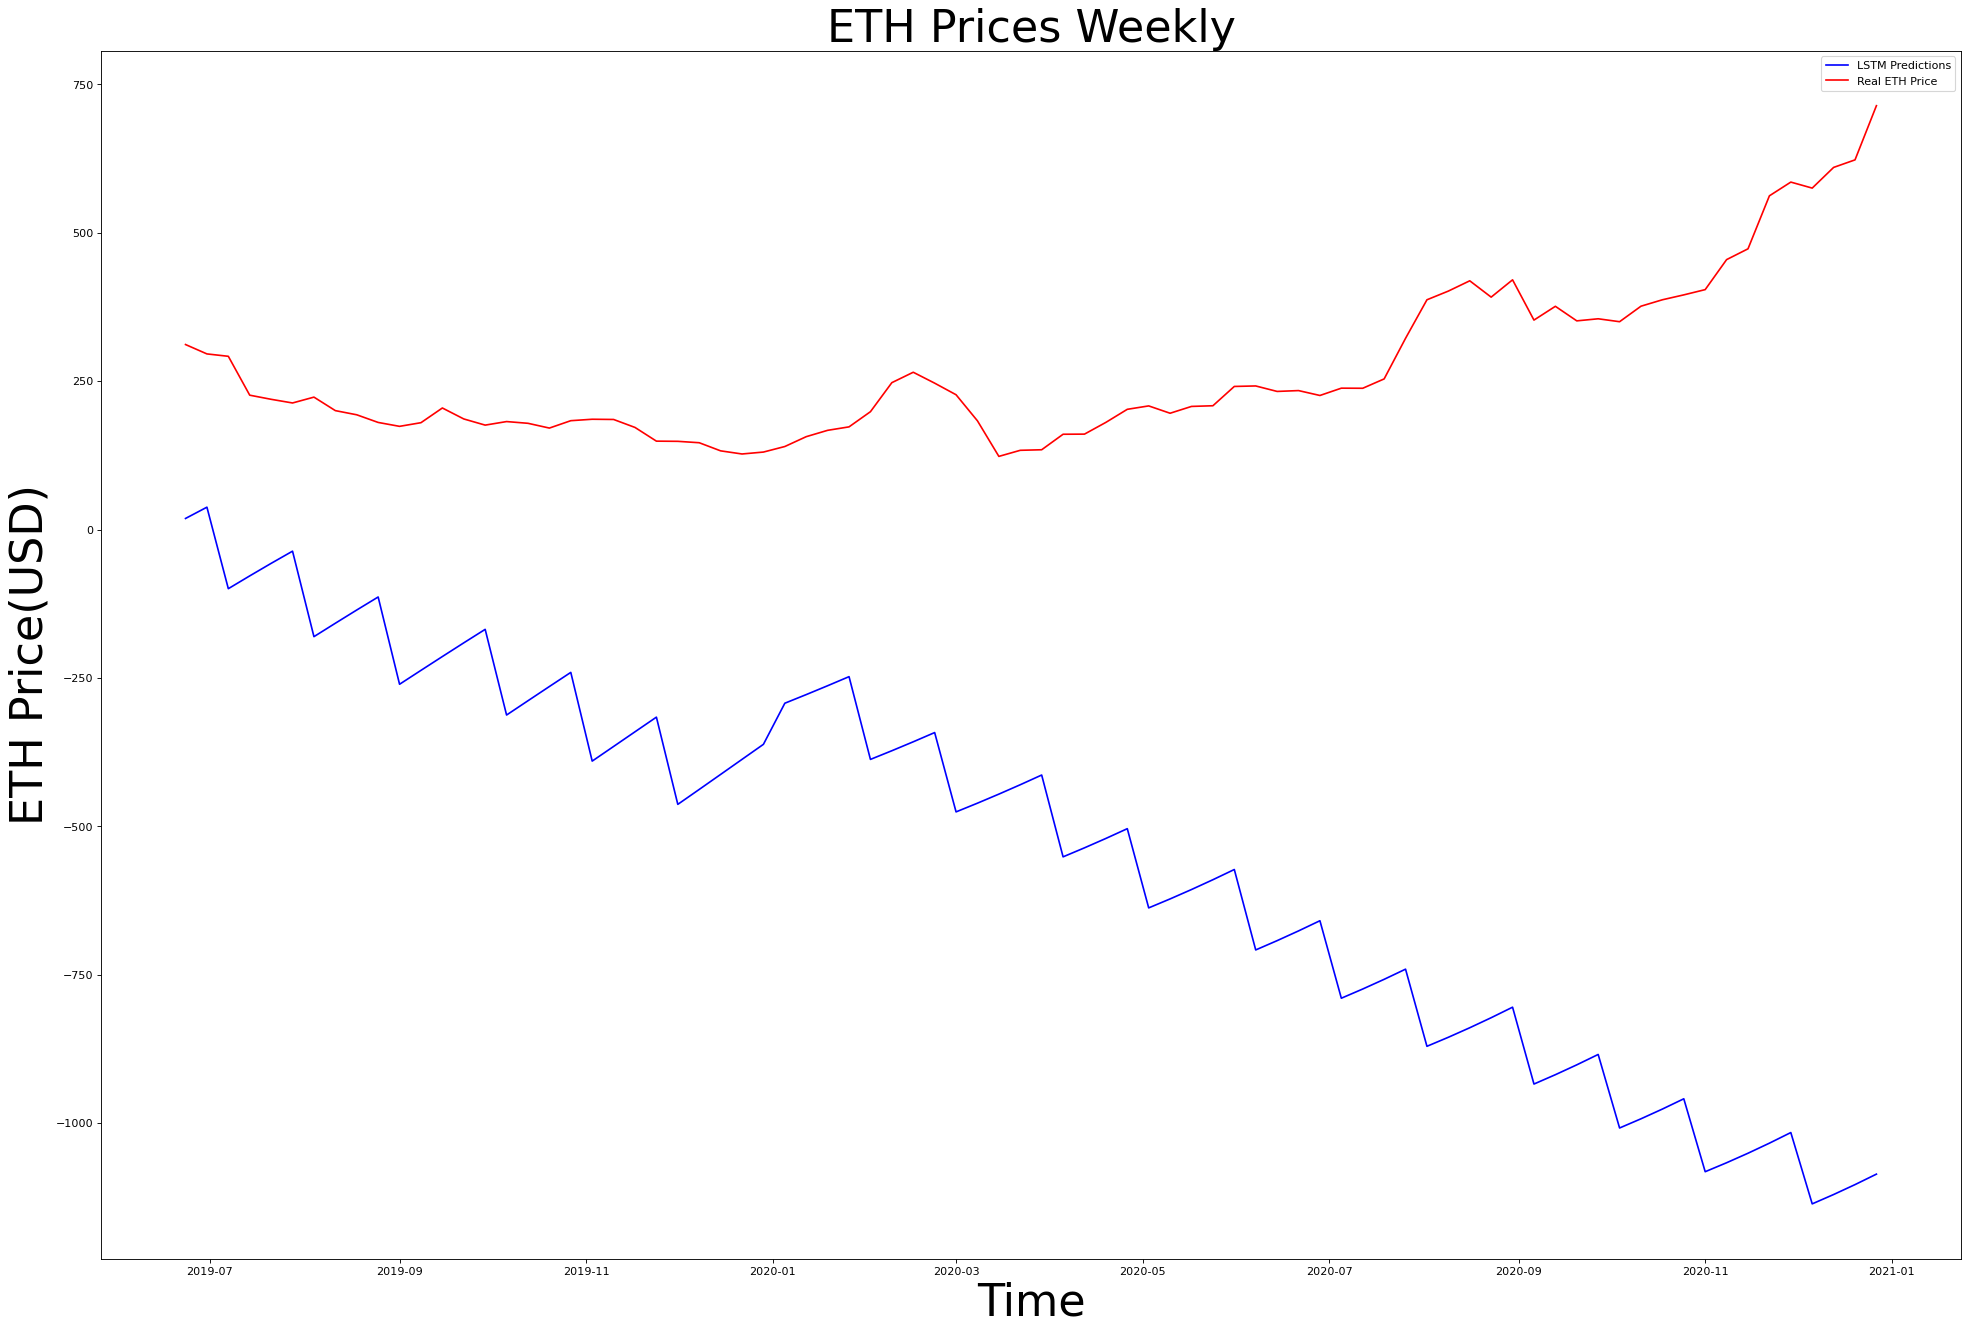

In [255]:
y_test_values = [float(i) for i in y_test]
# The Prices of Bitcoin over time
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test.index,y_test_values, color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.legend()
plt.show()

<ipython-input-256-39ecf541e2db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_x['Mean Prices'] = y_train['Mean Weekly Prices']


<AxesSubplot:>

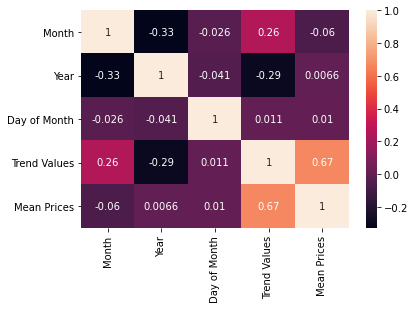

In [256]:
# To see the correlation values
dummy_x = X_train
dummy_x['Mean Prices'] = y_train['Mean Weekly Prices']
sns.heatmap(dummy_x.corr(),annot = True)